In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import random

from datetime import date

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,balanced_accuracy_score

## load data

In [8]:
data = pd.read_pickle('../results/us_air_data_weight_change.pkl').replace([np.inf, -np.inf], np.nan).dropna(how='all')
#data['passenges_centrality'] = data['passenges_centrality'].astype(np.int64)
data = data[data.year>=date(2004,1,1)]
rename_dict = {}
for column in data.columns:
    if '_index' in column:
        column_v = column.replace('_index','',1)
    else:
        column_v =  column
    rename_dict[column]=column_v.replace('_',' ',3).title()
    
rename_again = {'Common Neighbor' : 'CN', 'Salton':'SA' , 'Jaccard':'JA', 'Sorensen':'SO', 'Hub Promoted':'HPI',
       'Hub Depressed':'HDI', 'Leicht Holme Newman':'LHNI', 'Preferential Attachment':'PA',
       'Adamic Adar':'AA', 'Resource Allocation':'RA', 'Local Path':'LP'}
    
data_air = data.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})

columns=['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
       'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
       'Adamic Adar', 'Resource Allocation', 'Local Path',
        'Year','Edge','Time','Label']
#'Edge Betweeness Centrality','Core Max', 'Core Min',
data_air =  data_air[columns].rename(columns=rename_again)

In [9]:
data_bus = pd.read_pickle('../results/brazil_bus_data_weight_change.pkl').replace([np.inf, -np.inf], np.nan).dropna(how='all')
data_bus = data_bus.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})
data_bus =  data_bus[columns].rename(columns=rename_again)

In [11]:
def my_fun(x):
    if x>0:
        return(1)
    if x<0:
        return(-1)
    else:
        return(0)
    
data_air['Label'] = data_air['Label'].apply(lambda x: my_fun(x))
data_bus['Label'] = data_bus['Label'].apply(lambda x: my_fun(x))

## split edges into training and testing

In [12]:
def get_edge_slice(data,f_train_e=0.7,seed=30):
    df = data
    edges = list(df.Edge.unique())
    random.seed(seed)
    edge_train = random.sample(edges,int(f_train_e*len(edges)))
    edge_test = [e for e in edges if e not in edge_train]
    df_se = df.loc[df['Edge'].isin(edge_train)].drop(columns = ['Edge','Time'])
    df_de = df.loc[df['Edge'].isin(edge_test)].drop(columns = ['Edge','Time'])
    return(df_se,df_de)

def get_time_slice(data,time_start,time_end,droptime=True):
    if droptime:
        return(data[data.Year >= time_start][data.Year <= time_end].drop(columns = ['Year']))
    else:
        return(data[data.Year >= time_start][data.Year <= time_end])

def df_to_XY(df):
    if 'Year' in df.columns: 
        df = df.drop(columns = ['Year'])
        if "Edge" in df.columns:
            df = df.drop(columns = ['Edge'])
    X,y = df.loc[:, df.columns != 'Label'].to_numpy(),\
    df.loc[:, df.columns == 'Label'].to_numpy()
    return(X,y)

In [14]:
air_se,air_de = get_edge_slice(data_air)
bus_se,bus_de = get_edge_slice(data_bus)

In [16]:
warnings.simplefilter(action='ignore')

In [17]:
data = data_air
years_air = data.Year.unique()
air_plus,air_minus,air_0 = [],[],[]
for y in years_air:
    air_plus.append(len(data[data.Year==y][data.Label>0])/len(data[data.Year==y]))
    air_minus.append(len(data[data.Year==y][data.Label<0])/len(data[data.Year==y]))
    air_0.append(len(data[data.Year==y][data.Label==0])/len(data[data.Year==y]))

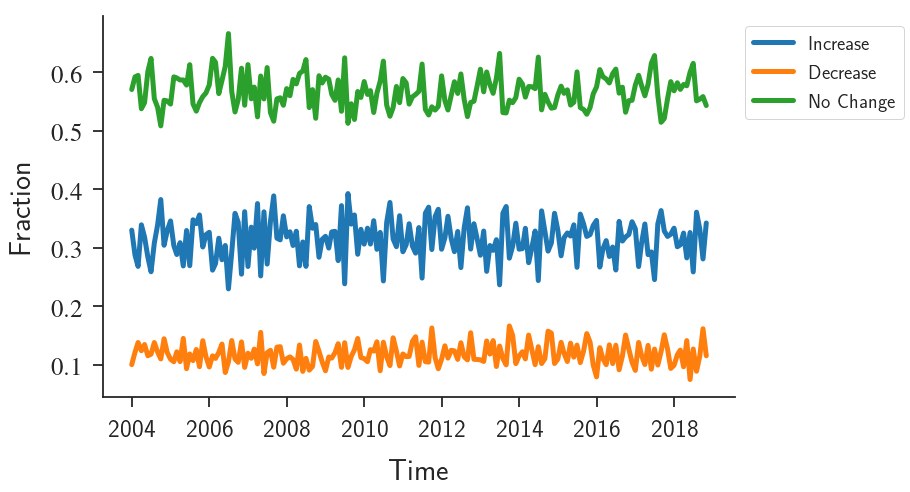

In [18]:
fig,ax=plt.subplots(figsize=(xs,ys))
plt.plot(years_air,air_plus,label='Increase')
plt.plot(years_air,air_minus,label='Decrease')
plt.plot(years_air,air_0,label='No Change')
plt.legend(bbox_to_anchor=(1.0, 1))
plt.xlabel('Time')
plt.ylabel('Fraction')
custom_frame(ax)
plt.savefig('../figures/weight_change_fraction_air.pdf',transparent=True)
plt.show()

In [21]:
data = data_bus
years_bus = data.Year.unique()
bus_plus,bus_minus,bus_0 = [],[],[]
for y in years_bus:
    bus_plus.append(len(data[data.Year==y][data.Label>0])/len(data[data.Year==y]))
    bus_minus.append(len(data[data.Year==y][data.Label<0])/len(data[data.Year==y]))
    bus_0.append(len(data[data.Year==y][data.Label==0])/len(data[data.Year==y]))

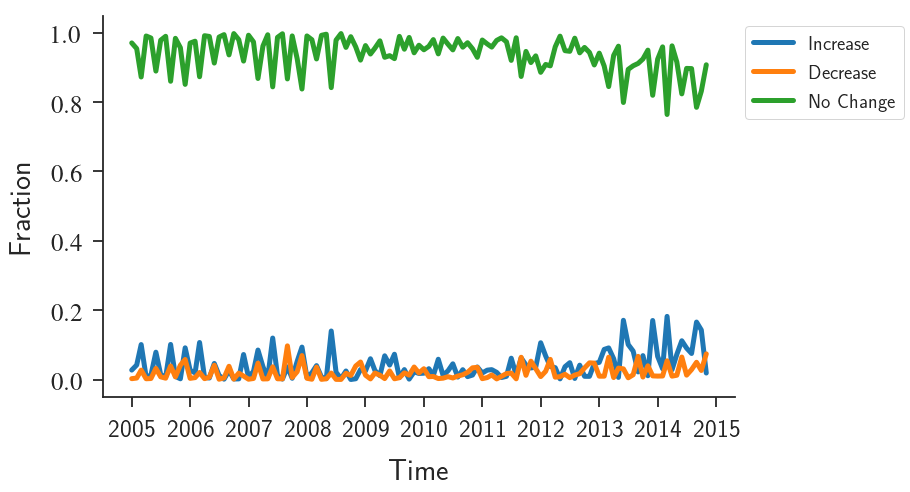

In [22]:
fig,ax=plt.subplots(figsize=(xs,ys))
plt.plot(years_bus,bus_plus,label='Increase')
plt.plot(years_bus,bus_minus,label='Decrease')
plt.plot(years_bus,bus_0,label='No Change')
plt.legend(bbox_to_anchor=(1.0, 1))
plt.xlabel('Time')
plt.ylabel('Fraction')
custom_frame(ax)
plt.savefig('../figures/weight_change_fraction_bus.pdf',transparent=True)
plt.show()

## structural test

In [23]:
def average_confusion_matrix(df_train,df_test,get_null=False, year_train=date(2004,1,1),year_test = date(2004,2,1),N=10):
    X_train,y_train  = df_to_XY(df_train[df_train.Year==year_train])
    X_test,y_test = df_to_XY(df_test[df_test.Year==year_test])
    ros = RandomUnderSampler()
    cms = []
    cms_null = []
    for i in range(N):
        X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
        model = XGBClassifier()
        model.fit(X_resampled,y_resampled)
        y_predict = model.predict(X_test)    
        cm = confusion_matrix(y_test,y_predict,labels = [-1,0,1])
        cms.append(cm.astype('float') / cm.sum(axis = 1)[:,None])
        if get_null == True:
            y_train_shuffled = np.copy(y_train)
            np.random.shuffle(y_train_shuffled)
            ros = RandomUnderSampler()
            Xnull_resampled, ynull_resampled = ros.fit_resample(X_train,y_train_shuffled)
            null = XGBClassifier()
            null.fit(Xnull_resampled,ynull_resampled)
            y_predict = model.predict(X_test)    
            cm = confusion_matrix(y_test,y_predict,labels = [-1,0,1])
            cms_null.append(cm.astype('float') / cm.sum(axis = 1)[:,None])         
    return(np.average(cms,axis=0),np.average(cms_null,axis=0))


def pure_plot_confusion_matrix(cm, ax = None):
    classes = ['Dec','0','Inc']
    #classes = [0,1]
    sns.heatmap(cm, square = True, annot= True, cbar = False, cmap=plt.cm.Blues,ax = ax,annot_kws={"fontsize":25})
    ax.set_ylim(0,3)
    ax.tick_params( bottom=False, right=False,left=False, labeltop=False, labelbottom=True)
    ax.invert_yaxis()
    ax.set(xticks = np.arange(cm.shape[1])+0.5,
           yticks = np.arange(cm.shape[0])+0.35,
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel = 'True label',
           xlabel = 'Predicted label') 

In [24]:
def structural_test(df_se,df_de,N=500):
    year_list = list(df_se.Year.unique())
    accuracies_of_all_network = []
    accuracies_of_all_network_null = []      
    for year in year_list:
        try:
            bas,bas_null= [],[]
            for i in range(N):
                X_train,y_train = df_to_XY(df_se[df_se.Year==year])
                X_test,y_test = df_to_XY(df_de[df_de.Year==year])
                ros = RandomUnderSampler()
                X_resampled, y_resampled = ros.fit_resample(X_train,y_train)

                y_train_shuffled = np.copy(y_train)
                #np.random.seed(30)
                np.random.shuffle(y_train_shuffled)
                ros = RandomUnderSampler()
                Xnull_resampled, ynull_resampled = ros.fit_resample(X_train,y_train_shuffled)

                model = XGBClassifier()
                model.fit(X_resampled,y_resampled)
                null = XGBClassifier()
                null.fit(Xnull_resampled,ynull_resampled)

                y_i_pred = model.predict(X_test)
                y_i_pred_null = null.predict(X_test)
                bas.append(balanced_accuracy_score(y_test, y_i_pred))
                bas_null.append(balanced_accuracy_score(y_test,y_i_pred_null))
            accuracies_of_all_network.append(np.mean(bas))   
            accuracies_of_all_network_null.append(np.mean(bas_null)) 
        except:
            pass
    return(year_list,accuracies_of_all_network,accuracies_of_all_network_null)

In [35]:
warnings.simplefilter(action='ignore')

In [25]:
cm_structure_air,_ = average_confusion_matrix(air_se,
                                              air_de,
                                              year_train=date(2004,1,1),
                                              year_test=date(2004,1,1),
                                              N=500)

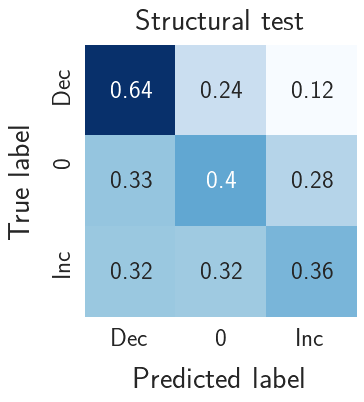

In [26]:
fig,ax =plt.subplots(figsize=(5,5))
plt.title("Structural test")
pure_plot_confusion_matrix(cm_structure_air,ax=ax)
plt.savefig('../figures/weight_change_confusion_matrix_structural_air.pdf',transparent=True)
plt.show()

In [27]:
air_structural = structural_test(air_se,air_de,N=100)

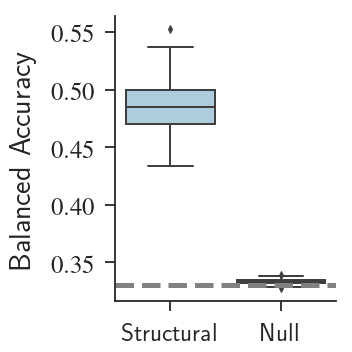

In [71]:
df = pd.concat([pd.DataFrame(dict(Model='Structural',Accuracy=air_structural[1])),                               
                pd.DataFrame(dict(Model='Null',Accuracy=air_structural[2]))])
fig,ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(x="Model", y="Accuracy",palette='Paired', data=df,ax=ax,linewidth=2)
plt.xticks(rotation=0, ha='center')
custom_frame(ax)
plt.ylabel('Balanced\ Accuracy')
plt.xlabel('')
plt.tight_layout()
ax.axhline(y=0.33, linestyle = '--',color ='grey')
plt.savefig('../figures/weight_change_balanced_accuracy_structural_air.pdf',transparent=True)
plt.show()

In [48]:
cm_structure_bus,_ = average_confusion_matrix(bus_se,
                                              bus_de,
                                              year_train=date(2005,1,1),
                                              year_test=date(2005,1,1),
                                              N=500)

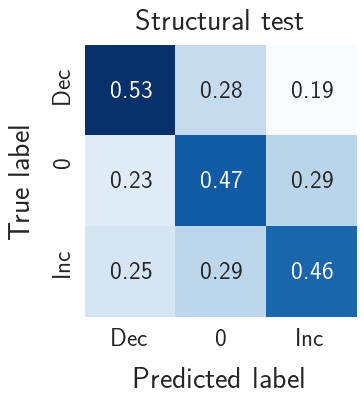

In [49]:
fig,ax =plt.subplots(figsize=(5,5))
plt.title("Structural test")
pure_plot_confusion_matrix(cm_structure_bus,ax=ax)
plt.savefig('../figures/weight_change_confusion_matrix_structural_bus.pdf',transparent=True)
plt.show()

In [50]:
bus_structural = structural_test(bus_se,bus_de,N=100)

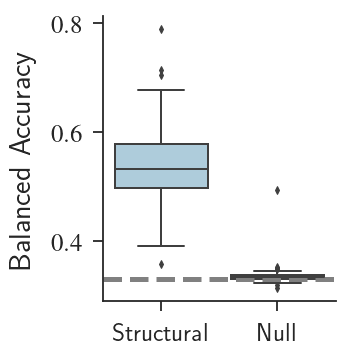

In [70]:
df = pd.concat([pd.DataFrame(dict(Model='Structural',Accuracy=bus_structural[1])),                               
                pd.DataFrame(dict(Model='Null',Accuracy=bus_structural[2]))])
fig,ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(x="Model", y="Accuracy",palette='Paired', data=df,ax=ax,linewidth=2)
plt.xticks(rotation=0, ha='center')
custom_frame(ax)
plt.ylabel('Balanced\ Accuracy')
plt.xlabel('')
plt.tight_layout()
ax.axhline(y=0.33, linestyle = '--',color ='grey')
plt.savefig('../figures/weight_change_balanced_accuracy_structural_bus.pdf',transparent=True)
plt.show()

## temoral test

In [52]:
def temporal_general_test(df_train,df_test):
    year_list = list(df_test.Year.unique())
    accuracy,accuracy_null = [], []
    for year_train in year_list:
        try:
            X_train,y_train = df_to_XY(df_train[df_train.Year==year_train])   
            ros = RandomUnderSampler()
            X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
            y_train_shuffled = np.copy(y_train)
            np.random.shuffle(y_train_shuffled)
            ros = RandomUnderSampler()
            Xnull_resampled, ynull_resampled = ros.fit_resample(X_train,y_train_shuffled)
            model = XGBClassifier()
            model.fit(X_resampled,y_resampled)
            null = XGBClassifier()
            null.fit(Xnull_resampled,ynull_resampled)
            i = year_list.index(year_train)
            for year_test in year_list[i:]:
                X_test,y_test = df_to_XY(df_test[df_test.Year==year_test])
                y_pred = model.predict(X_test)
                y_pred_null = null.predict(X_test)            
                accuracy.append(balanced_accuracy_score(y_test,y_pred))
                accuracy_null.append(balanced_accuracy_score(y_test,y_pred_null))
        except:
            pass
    return(accuracy,accuracy_null)

In [53]:
cm_temporal_air,_ = average_confusion_matrix(air_se,
                                             air_se,
                                             year_train=date(2004,1,1),
                                             year_test=date(2004,2,1),
                                             N=500)

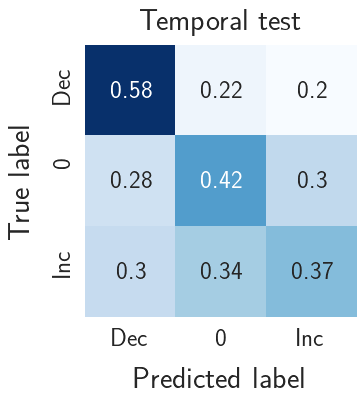

In [54]:
fig,ax =plt.subplots(figsize=(5,5))
plt.title("Temporal test")
pure_plot_confusion_matrix(cm_temporal_air,ax=ax)
plt.savefig('../figures/weight_change_confusion_matrix_temporal_air.pdf',transparent=True)
plt.show()

In [55]:
air_temporal = temporal_general_test(air_se,air_se)

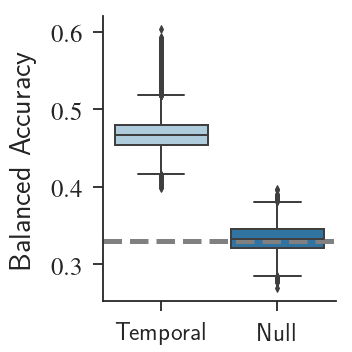

In [69]:
df = pd.concat([pd.DataFrame(dict(Model='Temporal',Accuracy=air_temporal[0])),                               
                pd.DataFrame(dict(Model='Null',Accuracy=air_temporal[1]))])
fig,ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(x="Model", y="Accuracy",palette='Paired', data=df,ax=ax,linewidth=2)
plt.xticks(rotation=0, ha='center')
custom_frame(ax)
plt.ylabel('Balanced\ Accuracy')
plt.xlabel('')
plt.tight_layout()
ax.axhline(y=0.33, linestyle = '--',color ='grey')
plt.savefig('../figures/weight_change_balanced_accuracy_temporal_air.pdf',transparent=True)
plt.show()

In [57]:
cm_temporal_bus,_ = average_confusion_matrix(bus_se,bus_se,year_train=date(2005,1,1),year_test=date(2005,2,1),N=500)

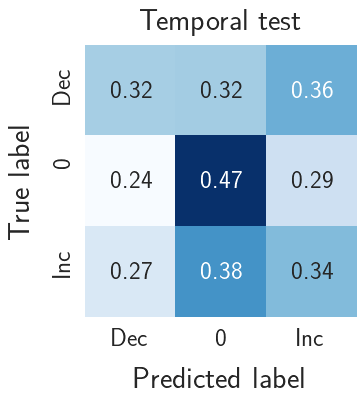

In [58]:
fig,ax =plt.subplots(figsize=(5,5))
plt.title("Temporal test")
pure_plot_confusion_matrix(cm_temporal_bus,ax=ax)
plt.savefig('../figures/weight_change_confusion_matrix_temporal_bus.pdf',transparent=True)
plt.show()

In [59]:
bus_temporal = temporal_general_test(bus_se,bus_se)

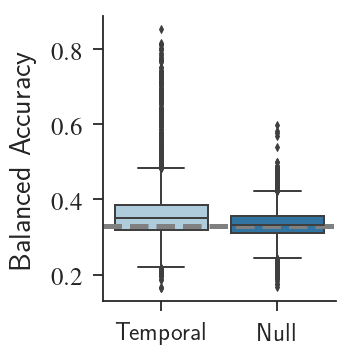

In [68]:
df = pd.concat([pd.DataFrame(dict(Model='Temporal',Accuracy=bus_temporal[0])),                               
                pd.DataFrame(dict(Model='Null',Accuracy=bus_temporal[1]))])
fig,ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(x="Model", y="Accuracy",palette='Paired', data=df,ax=ax,linewidth=2)
plt.xticks(rotation=0, ha='center')
custom_frame(ax)
plt.ylabel('Balanced\ Accuracy')
plt.xlabel('')
plt.tight_layout()
ax.axhline(y=0.33, linestyle = '--',color ='grey')
plt.savefig('../figures/weight_change_balanced_accuracy_temporal_bus.pdf',transparent=True)
plt.show()

## general test

In [61]:
cm_general_air,_ = average_confusion_matrix(air_se,
                                            air_de,
                                            year_train=date(2004,1,1),
                                            year_test=date(2004,2,1),
                                            N=500)

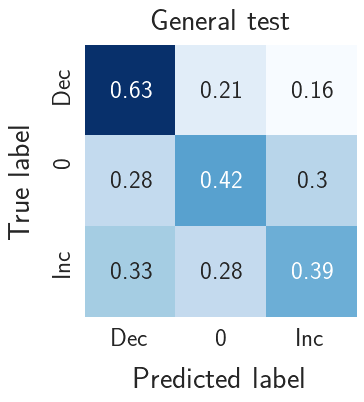

In [62]:
fig,ax =plt.subplots(figsize=(5,5))
plt.title("General test")
pure_plot_confusion_matrix(cm_general_air,ax=ax)
plt.savefig('../figures/weight_change_confusion_matrix_general_air.pdf',transparent=True)
plt.show()

In [63]:
air_general = temporal_general_test(air_se,air_de)

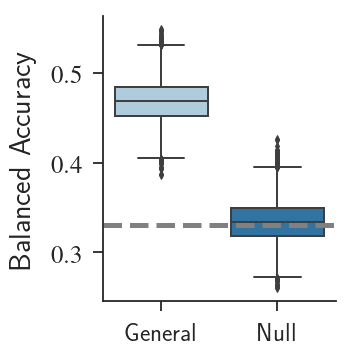

In [72]:
df = pd.concat([pd.DataFrame(dict(Model='General',Accuracy=air_general[0])),                               
                pd.DataFrame(dict(Model='Null',Accuracy=air_general[1]))])
fig,ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(x="Model", y="Accuracy",palette='Paired', data=df,ax=ax,linewidth=2)
plt.xticks(rotation=0, ha='center')
custom_frame(ax)
plt.ylabel('Balanced\ Accuracy')
plt.xlabel('')
plt.tight_layout()
ax.axhline(y=0.33, linestyle = '--',color ='grey')
plt.savefig('../figures/weight_change_balanced_accuracy_general_air.pdf',transparent=True)
plt.show()

In [65]:
cm_general_bus,_ = average_confusion_matrix(bus_se,
                                            bus_de,
                                            year_train=date(2005,1,1),
                                            year_test=date(2005,2,1),
                                            N=500)

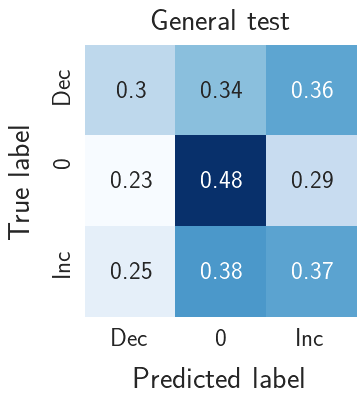

In [66]:
fig,ax =plt.subplots(figsize=(5,5))
plt.title("General test")
pure_plot_confusion_matrix(cm_general_bus,ax=ax)
plt.savefig('../figures/weight_change_confusion_matrix_general_bus.pdf',transparent=True)
plt.show()

In [67]:
bus_general = temporal_general_test(bus_se,bus_de)

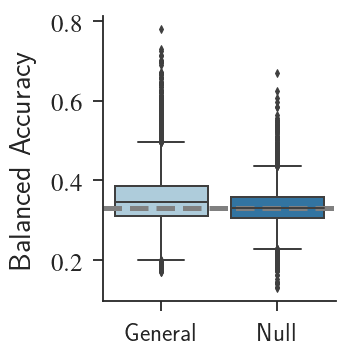

In [73]:
df = pd.concat([pd.DataFrame(dict(Model='General',Accuracy=bus_general[0])),                            
                pd.DataFrame(dict(Model='Null',Accuracy=bus_general[1]))])
fig,ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(x="Model", y="Accuracy",palette='Paired', data=df,ax=ax,linewidth=2)
plt.xticks(rotation=0, ha='center')
custom_frame(ax)
plt.ylabel('Balanced\ Accuracy')
plt.xlabel('')
plt.tight_layout()
ax.axhline(y=0.33, linestyle = '--',color ='grey')
plt.savefig('../figures/weight_change_balanced_accuracy_general_bus.pdf',transparent=True)
plt.show()

## model explain--SHAP values

In [81]:
import shap

In [85]:
def all_shap_values(df1,df2,clf=XGBClassifier()):
    shap_values_list = []
    year_list = []
    features = df1.columns[0:11]
    for i in df2.Year.unique():
        try:
            X_train,y_train = df_to_XY(df1[ df1.Year == i ].drop(columns = ['Year']))
            X_test,y_test = df_to_XY(df2[ df2.Year == i ].drop(columns = ['Year']))
            ros = RandomUnderSampler()
            X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
            clf.fit(X_resampled,y_resampled)  
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_test)
#         fig,ax = plt.subplots()
#         plt.title(i)
#         shap.summary_plot(shap_values, pd.DataFrame(X_test,columns=features),alpha=0.7,show=False)
#         plt.xlabel(ax.xaxis.get_label().get_text(),fontsize=30)
#         plt.xticks(fontsize=20)
#         plt.yticks(fontsize=25)
            year_list.append(i)
            shap_values_list.append(shap_values)
        except:
            pass
    return(year_list,shap_values_list)  

In [86]:
bus_year_list,bus_shap_values_list = all_shap_values(bus_se,bus_de)

In [87]:
air_year_list,air_shap_values_list = all_shap_values(air_se,air_de)

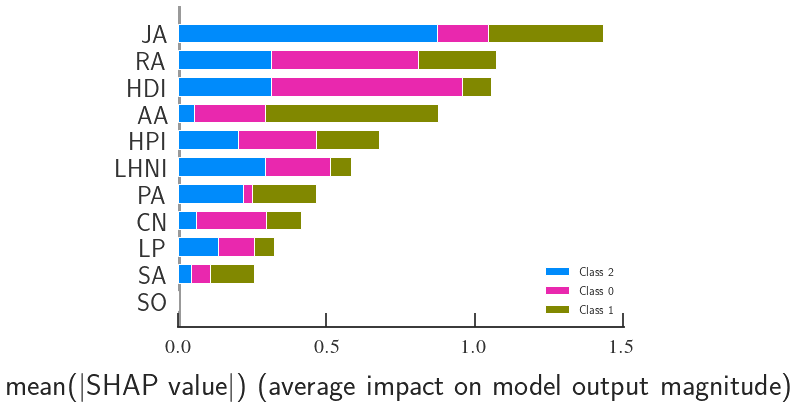

In [95]:
year = date(2005,1,1)
idx = bus_year_list.index(year)
shap_values = bus_shap_values_list[idx]
df=bus_de
features = df.columns[0:11]
X_test = df_to_XY(df[df.Year==year].drop(columns = ['Year']))[0]
fig,ax = plt.subplots()
shap.summary_plot(shap_values, pd.DataFrame(X_test,columns=features),alpha=0.7,show=False)
plt.xlabel(ax.xaxis.get_label().get_text(),fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.savefig('../figures/weight_change_bus_shap.svg',transparent=True)
plt.show()

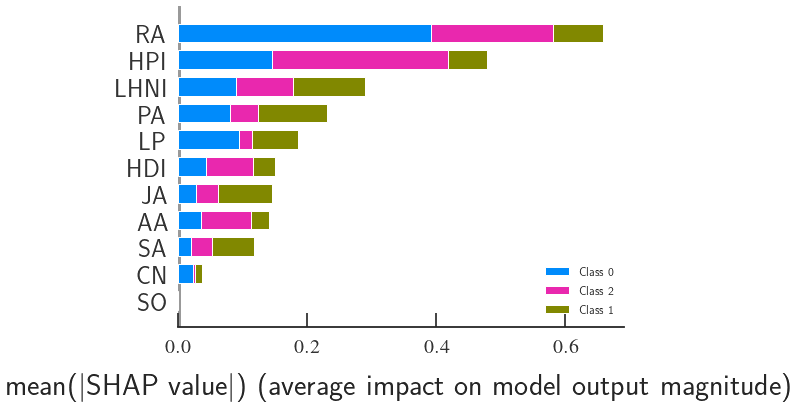

In [96]:
year = date(2004,1,1)
idx = air_year_list.index(year)
shap_values = air_shap_values_list[idx]
df=air_de
features = df.columns[0:11]
X_test = df_to_XY(df[df.Year==year].drop(columns = ['Year']))[0]

fig,ax = plt.subplots()
shap.summary_plot(shap_values, pd.DataFrame(X_test,columns=features),alpha=0.7,show=False)
plt.xlabel(ax.xaxis.get_label().get_text(),fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.savefig('../figures/weight_change_air_shap.svg',transparent=True)
plt.show()

In [90]:
def get_temporal_order(shap_list):
    importance_array = []
    for shap_values in shap_list: 
        array = -np.abs(shap_values).mean(0).mean(0)
        order = array.argsort()
        ranks = order.argsort()
        importance_array.append(ranks+1)
    return(np.array(importance_array))

In [91]:
bus_importance = get_temporal_order(bus_shap_values_list)
air_importance = get_temporal_order(air_shap_values_list)

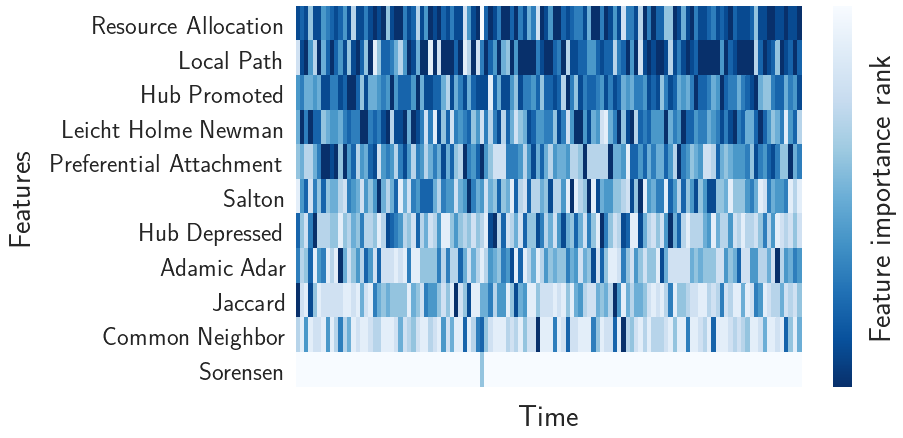

In [92]:
fig,ax = plt.subplots(figsize=(xs,ys))
importance = bus_importance
x= [j for _,j in sorted(zip(importance.T.mean(1),importance.T))]
y=  [j for _,j in sorted(zip(importance.T.mean(1),list(rename_again.keys())))]
ax = sns.heatmap(x,
                 cmap=mpl.cm.get_cmap('Blues_r'),
                 yticklabels=y,
                 xticklabels=False,
                 cbar_kws={'label': 'Feature importance rank',
                           'ticks': [-1,-3,-5,-7,-9,-11] }
                )
plt.ylabel('Features')
plt.xlabel('Time')
plt.savefig('../figures/weight_change_bus_shap_all.pdf',transparent=True)
plt.show()

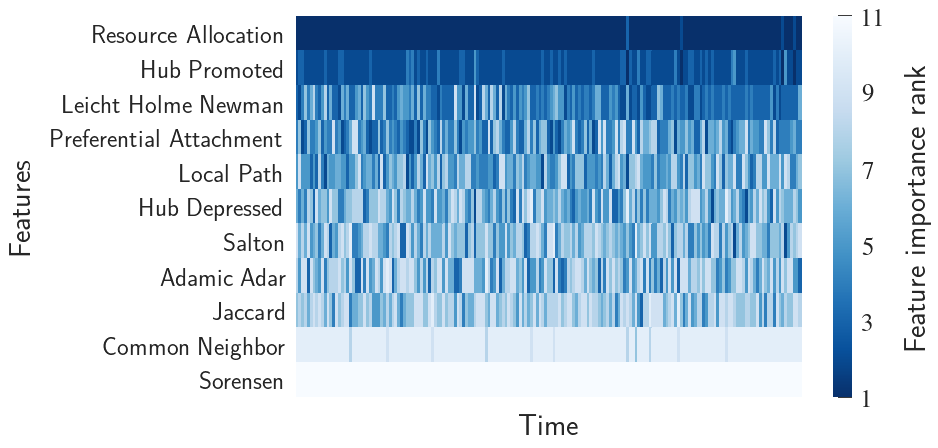

In [93]:
fig,ax = plt.subplots(figsize=(xs,ys))
importance = air_importance
x= [j for _,j in sorted(zip(importance.T.mean(1),importance.T))]
y=  [j for _,j in sorted(zip(importance.T.mean(1),list(rename_again.keys())))]
ax = sns.heatmap(x,
                 cmap=mpl.cm.get_cmap('Blues_r'),
                 yticklabels=y,
                 xticklabels=False,
                 cbar_kws={'label': 'Feature importance rank',
                           'ticks': [1,3,5,7,9,11] }
                )
plt.ylabel('Features')
plt.xlabel('Time')
plt.savefig('../figures/weight_change_air_shap_all.pdf',transparent=True)
plt.show()